<img style="float: right; margin: 5px 5px 20px 20px;" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width="100px" height="75px"/>

# 003 Deep learning

### Microstructures and trading systems

> **Evelin Ramirez, Pedro Gael Rayas**

## Resumen

## Introducción 

## Metodología y código

### 0. Importar librerías 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import ta
import logging
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

### 1. Carga de datos 

* Se utiliza el archivo CSV 'aapl_5m_train.csv' proporcionado por el profesor, que contiene datos históricos de las acciones de Apple registrados cada 5 minutos. Los datos abarcan el período comprendido desde el 04 de enero de 2021 a las 14:30:00 hasta el 30 de diciembre de 2022 a las 21:00:00.

In [2]:
# Carga de datos
data = pd.read_csv('aapl_5m_train.csv').dropna()
print(f"Tamaño inicial de data: {len(data)}")

Tamaño inicial de data: 39160


### 2. Preparación y Entrenamiento del Modelo LSTM

Se normalizan las variables y se generan secuencias temporales mediante una ventana de lookback para capturar la dinámica de los precios y los indicadores. Posteriormente, se construye y entrena un modelo LSTM con dos capas (50 unidades cada una), intercalando capas de dropout para reducir el sobreajuste, y se utiliza la salida para clasificar la dirección del cambio en el precio.

In [3]:
# Función para preparar datos para LSTM
def prepare_lstm_data(dataset, lookback=20):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset[["Close", "RSI", "BB", "MACD", "MACD_signal"]])
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])
        y.append(1 if dataset["Close"].iloc[i] > dataset["Close"].iloc[i-1] else 0)
    X = np.array(X)
    y = np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test, scaler

In [4]:
# Función para crear y entrenar el modelo LSTM
def train_lstm(X_train, y_train, lookback=20):
    model = Sequential()
    model.add(Input(shape=(lookback, 5)))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
    return model

### 3. Cálculo de Métricas de Desempeño

Esta función evalúa la eficiencia de la estrategia de trading a través de los siguientes pasos:

* Se convierte la evolución del portafolio en retornos porcentuales.
* Se calcula el Sharpe Ratio dividiendo la media de los retornos (ajustada por una tasa libre de riesgo) entre su desviación estándar y anualizando el resultado.
* El Sortino Ratio se obtiene de forma similar, pero usando solo los retornos negativos para medir el riesgo a la baja.
* El Calmar Ratio se determina dividiendo el retorno anualizado entre el máximo drawdown, representando la peor caída acumulada del portafolio.
* Se calcula el porcentaje de operaciones ganadoras sobre el total de operaciones para obtener el Win/Loss Percentage.
* Esta metodología permite evaluar tanto la rentabilidad como la gestión del riesgo de la estrategia.

In [5]:
# Función para calcular métricas
def calculate_metrics(portfolio_value, wins, losses):
    portfolio_series = pd.Series(portfolio_value)
    if len(portfolio_series) < 2:
        print("Error: portfolio_value tiene menos de 2 elementos")
        return {"Sharpe": 0, "Sortino": 0, "Calmar": 0, "Win_Loss_Percent": 0}
    
    returns = portfolio_series.pct_change().dropna()
    if len(returns) == 0:
        print("Error: No hay retornos válidos")
        return {"Sharpe": 0, "Sortino": 0, "Calmar": 0, "Win_Loss_Percent": 0}
    
    risk_free_rate = 0.0
    sharpe = (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252 * 12)
    downside_returns = returns[returns < 0]
    sortino = (returns.mean() - risk_free_rate) / downside_returns.std() * np.sqrt(252 * 12) if len(downside_returns) > 0 else 0
    cumulative_returns = (portfolio_series / portfolio_series.iloc[0] - 1)
    max_drawdown = abs(cumulative_returns.min()) if cumulative_returns.min() != 0 else 1e-10
    annual_return = (portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1) * (252 * 12 / len(returns))
    calmar = annual_return / max_drawdown
    total_trades = wins + losses
    win_loss = wins / total_trades * 100 if total_trades > 0 else 0
    
    return {
        "Sharpe": sharpe if not np.isnan(sharpe) else 0,
        "Sortino": sortino if not np.isnan(sortino) else 0,
        "Calmar": calmar if not np.isnan(calmar) else 0,
        "Win_Loss_Percent": win_loss
    }

### 4. Función Objetivo para Optimización

Esta función se utiliza para evaluar la estrategia de trading en cada prueba de Optuna. En resumen, realiza los siguientes pasos:

Generación de Hiperparámetros:
* Se definen rangos para parámetros críticos (ventana y umbrales del RSI, stop loss, take profit, número de acciones y lookback) utilizando las sugerencias de Optuna.

Cálculo de Indicadores Técnicos:
* Se calculan los indicadores RSI, Bollinger Bands y MACD, y se añaden al dataset.

Preparación y Entrenamiento del Modelo LSTM:
* Se preparan los datos para el modelo (normalización y creación de secuencias temporales) y se entrena un modelo LSTM que se utiliza para predecir la dirección del movimiento del precio (compra/venta).

Generación de Señales de Trading:
* Se combinan las señales del modelo LSTM con las generadas por los indicadores técnicos para definir las órdenes de compra y venta.

Simulación de Trading (Backtesting):
* Se ejecuta un backtesting que simula operaciones (tanto long como short), actualizando el capital, el valor del portafolio y registrando las operaciones ganadoras y perdedoras.

Cálculo del Desempeño:
* Se calculan métricas clave (como el Sharpe Ratio, entre otras) a partir de la evolución del portafolio. El Sharpe ratio se devuelve como valor objetivo para la optimización.

Esta función permite iterar sobre distintas combinaciones de hiperparámetros para encontrar la configuración que maximice el rendimiento ajustado por riesgo de la estrategia.

In [6]:
def objective_fun(trial, data, verbose=False):
    rsi_window = trial.suggest_int("rsi_window", 10, 100)
    rsi_lower = trial.suggest_int("rsi_lower", 5, 35)
    rsi_upper = trial.suggest_int("rsi_upper", 65, 95)
    stop_loss = trial.suggest_float("stop_loss", 0.01, 0.2)
    take_profit = trial.suggest_float("take_profit", 0.01, 0.2)
    n_shares = trial.suggest_categorical("n_shares", [1000, 2000, 3000, 3500, 4000])
    lookback = trial.suggest_int("lookback", 10, 50)

    dataset = data.copy()
    rsi = ta.momentum.RSIIndicator(dataset.Close, window=rsi_window)
    bb = ta.volatility.BollingerBands(dataset.Close, window=15, window_dev=2)
    macd = ta.trend.MACD(dataset.Close, window_slow=26, window_fast=12, window_sign=9)
    dataset["RSI"] = rsi.rsi()
    dataset["BB"] = bb.bollinger_mavg()
    dataset["MACD"] = macd.macd()
    dataset["MACD_signal"] = macd.macd_signal()

    X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(dataset.dropna(), lookback=lookback)
    # print(f"Tamaño después de prepare_lstm_data: {len(dataset)}")
    model = train_lstm(X_train, y_train, lookback=lookback)

    scaled_data = scaler.transform(dataset[["Close", "RSI", "BB", "MACD", "MACD_signal"]])
    X_full = [scaled_data[i - lookback:i] for i in range(lookback, len(scaled_data))]
    X_full = np.array(X_full)
    lstm_preds = (model.predict(X_full, verbose=0) > 0.5).astype(int).flatten()

    dataset = dataset.iloc[lookback:].reset_index(drop=True)
    dataset["LSTM_BUY"] = pd.Series(lstm_preds) == 1
    dataset["LSTM_SELL"] = pd.Series(lstm_preds) == 0

    bb = ta.volatility.BollingerBands(dataset.Close, window=15, window_dev=2)
    dataset["RSI_BUY"] = dataset["RSI"] < rsi_lower
    dataset["RSI_SELL"] = dataset["RSI"] > rsi_upper
    dataset["BB_BUY"] = dataset.Close < bb.bollinger_lband()
    dataset["BB_SELL"] = dataset.Close > bb.bollinger_hband()
    dataset["MACD_BUY"] = dataset["MACD"] > dataset["MACD_signal"]
    dataset["MACD_SELL"] = dataset["MACD"] < dataset["MACD_signal"]

    # Simplificamos las señales para balancear compras y ventas
    dataset["BUY_SIGNAL"] = (dataset["LSTM_BUY"] | dataset["RSI_BUY"] | dataset["BB_BUY"] | dataset["MACD_BUY"])
    dataset["SELL_SIGNAL"] = (dataset["LSTM_SELL"] | dataset["RSI_SELL"] | dataset["BB_SELL"] | dataset["MACD_SELL"])

    dataset = dataset.dropna()
    # print(f"Tamaño final de dataset: {len(dataset)}")
    # print(f"Señales de compra: {dataset['BUY_SIGNAL'].sum()}, Señales de venta: {dataset['SELL_SIGNAL'].sum()}")

    capital = 1000000
    com = 0.5 / 100
    portfolio_value = [capital]
    active_long_pos = None
    active_short_pos = None
    wins = 0
    losses = 0

    for i, row in dataset.iterrows():
        if active_long_pos:
            if row.Close < active_long_pos["stop_loss"]:
                pnl = row.Close * n_shares * (1 - com) - active_long_pos["cost"]
                capital += active_long_pos["cost"] + pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_long_pos = None
                # print(f"Cierre por Stop Loss (long) en {row.Close}, Capital: {capital}")
            elif row.Close > active_long_pos["take_profit"]:
                pnl = row.Close * n_shares * (1 - com) - active_long_pos["cost"]
                capital += active_long_pos["cost"] + pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_long_pos = None
                # print(f"Cierre por Take Profit (long) en {row.Close}, Capital: {capital}")
        
        if active_short_pos:
            if row.Close > active_short_pos["stop_loss"]:
                pnl = active_short_pos["revenue"] - row.Close * n_shares * (1 + com)
                capital += pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_short_pos = None
                # print(f"Cierre por Stop Loss (short) en {row.Close}, Capital: {capital}")
            elif row.Close < active_short_pos["take_profit"]:
                pnl = active_short_pos["revenue"] - row.Close * n_shares * (1 + com)
                capital += pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_short_pos = None
                # print(f"Cierre por Take Profit (short) en {row.Close}, Capital: {capital}")

        if row["BUY_SIGNAL"] and active_long_pos is None and active_short_pos is None:
            cost = row.Close * n_shares * (1 + com)
            if capital > cost:
                capital -= cost
                active_long_pos = {
                    "datetime": row.Datetime,
                    "cost": cost,
                    "take_profit": row.Close * (1 + take_profit),
                    "stop_loss": row.Close * (1 - stop_loss)
                }
                # print(f"Compra en {row.Close}, Capital: {capital}")

        if row["SELL_SIGNAL"] and active_short_pos is None and active_long_pos is None:
            revenue = row.Close * n_shares * (1 - com)
            capital += revenue
            active_short_pos = {
                "datetime": row.Datetime,
                "revenue": revenue,
                "take_profit": row.Close * (1 - take_profit),
                "stop_loss": row.Close * (1 + stop_loss)
            }
            # print(f"Venta corta en {row.Close}, Capital: {capital}")

        long_value = row.Close * n_shares if active_long_pos else 0
        short_value = (active_short_pos["revenue"] - row.Close * n_shares) if active_short_pos else 0
        portfolio_value.append(capital + long_value + short_value)

    # print(f"Longitud de portfolio_value: {len(portfolio_value)}")
    if len(portfolio_value) <= 1:
        return -float('inf')
    metrics = calculate_metrics(portfolio_value, wins, losses)
    return metrics["Sharpe"]


In [ ]:
import logging
import time
import optuna
import pandas as pd
import numpy as np
import ta

# Assuming prepare_lstm_data, train_lstm, and calculate_metrics are defined elsewhere

def objective_fun(trial, data, verbose=False):
    start_time = time.time()  # Iniciar el temporizador

    # Configurar el nivel de logging según el parámetro verbose
    if verbose:
        logger.setLevel(logging.DEBUG)
    else:
        logger.setLevel(logging.WARNING)

    # Existing hyperparameters
    rsi_window = trial.suggest_int("rsi_window", 10, 100)
    rsi_lower = trial.suggest_int("rsi_lower", 5, 35)
    rsi_upper = trial.suggest_int("rsi_upper", 65, 95)
    stop_loss = trial.suggest_float("stop_loss", 0.01, 0.2)
    take_profit = trial.suggest_float("take_profit", 0.01, 0.2)
    n_shares = trial.suggest_categorical("n_shares", [1000, 2000, 3000, 3500, 4000])
    lookback = trial.suggest_int("lookback", 10, 50)

    # Bollinger Bands hyperparameters
    bb_window = trial.suggest_int("bb_window", 10, 50)  # Window for Bollinger Bands
    bb_window_dev = trial.suggest_float("bb_window_dev", 1.5, 3.0)  # Standard deviation multiplier

    # MACD hyperparameters
    macd_window_slow = trial.suggest_int("macd_window_slow", 20, 50)  # Slow EMA period
    macd_window_fast = trial.suggest_int("macd_window_fast", 5, macd_window_slow - 1)  # Fast EMA period, ensure it's less than slow
    macd_window_sign = trial.suggest_int("macd_window_sign", 5, 15)  # Signal line period

    dataset = data.copy()
    rsi = ta.momentum.RSIIndicator(dataset.Close, window=rsi_window)
    bb = ta.volatility.BollingerBands(dataset.Close, window=bb_window, window_dev=bb_window_dev)
    macd = ta.trend.MACD(dataset.Close, window_slow=macd_window_slow, window_fast=macd_window_fast, window_sign=macd_window_sign)
    dataset["RSI"] = rsi.rsi()
    dataset["BB"] = bb.bollinger_mavg()
    dataset["MACD"] = macd.macd()
    dataset["MACD_signal"] = macd.macd_signal()

    X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(dataset.dropna(), lookback=lookback)
    logger.debug(f"Tamaño después de prepare_lstm_data: {len(dataset)}")
    model = train_lstm(X_train, y_train, lookback=lookback)

    scaled_data = scaler.transform(dataset[["Close", "RSI", "BB", "MACD", "MACD_signal"]])
    X_full = [scaled_data[i - lookback:i] for i in range(lookback, len(scaled_data))]
    X_full = np.array(X_full)
    lstm_preds = (model.predict(X_full, verbose=0) > 0.5).astype(int).flatten()

    dataset = dataset.iloc[lookback:].reset_index(drop=True)
    dataset["LSTM_BUY"] = pd.Series(lstm_preds) == 1
    dataset["LSTM_SELL"] = pd.Series(lstm_preds) == 0

    bb = ta.volatility.BollingerBands(dataset.Close, window=bb_window, window_dev=bb_window_dev)
    dataset["RSI_BUY"] = dataset["RSI"] < rsi_lower
    dataset["RSI_SELL"] = dataset["RSI"] > rsi_upper
    dataset["BB_BUY"] = dataset.Close < bb.bollinger_lband()
    dataset["BB_SELL"] = dataset.Close > bb.bollinger_hband()
    dataset["MACD_BUY"] = dataset["MACD"] > dataset["MACD_signal"]
    dataset["MACD_SELL"] = dataset["MACD"] < dataset["MACD_signal"]

    # Simplificamos las señales para balancear compras y ventas
    dataset["BUY_SIGNAL"] = (dataset["LSTM_BUY"] | dataset["RSI_BUY"] | dataset["BB_BUY"] | dataset["MACD_BUY"])
    dataset["SELL_SIGNAL"] = (dataset["LSTM_SELL"] | dataset["RSI_SELL"] | dataset["BB_SELL"] | dataset["MACD_SELL"])

    dataset = dataset.dropna()
    logger.debug(f"Tamaño final de dataset: {len(dataset)}")
    logger.debug(f"Señales de compra: {dataset['BUY_SIGNAL'].sum()}, Señales de venta: {dataset['SELL_SIGNAL'].sum()}")

    capital = 1000000
    com = 0.5 / 100  # Comisión ajustada a un valor más realista
    portfolio_value = [capital]
    active_long_pos = None
    active_short_pos = None
    wins = 0
    losses = 0

    for i, row in dataset.iterrows():
        if active_long_pos:
            if row.Close < active_long_pos["stop_loss"]:
                pnl = row.Close * n_shares * (1 - com) - active_long_pos["cost"]
                capital += active_long_pos["cost"] + pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_long_pos = None
                logger.debug(f"Cierre por Stop Loss (long) en {row.Close}, Capital: {capital}")
            elif row.Close > active_long_pos["take_profit"]:
                pnl = row.Close * n_shares * (1 - com) - active_long_pos["cost"]
                capital += active_long_pos["cost"] + pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_long_pos = None
                logger.debug(f"Cierre por Take Profit (long) en {row.Close}, Capital: {capital}")

        if active_short_pos:
            if row.Close > active_short_pos["stop_loss"]:
                pnl = active_short_pos["revenue"] - row.Close * n_shares * (1 + com)
                capital += pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_short_pos = None
                logger.debug(f"Cierre por Stop Loss (short) en {row.Close}, Capital: {capital}")
            elif row.Close < active_short_pos["take_profit"]:
                pnl = active_short_pos["revenue"] - row.Close * n_shares * (1 + com)
                capital += pnl
                if pnl > 0:
                    wins += 1
                else:
                    losses += 1
                active_short_pos = None
                logger.debug(f"Cierre por Take Profit (short) en {row.Close}, Capital: {capital}")

        if row["BUY_SIGNAL"] and active_long_pos is None and active_short_pos is None:
            cost = row.Close * n_shares * (1 + com) * 1.001  # 0.1% de slippage para compra
            if capital > cost:
                capital -= cost
                active_long_pos = {
                    "datetime": row.Datetime,
                    "cost": cost,
                    "take_profit": row.Close * (1 + take_profit),
                    "stop_loss": row.Close * (1 - stop_loss)
                }
                logger.debug(f"Compra en {row.Close}, Capital: {capital}")

        if row["SELL_SIGNAL"] and active_short_pos is None and active_long_pos is None:
            revenue = row.Close * n_shares * (1 - com) * 0.999  # 0.1% de slippage para venta corta
            capital += revenue
            active_short_pos = {
                "datetime": row.Datetime,
                "revenue": revenue,
                "take_profit": row.Close * (1 - take_profit),
                "stop_loss": row.Close * (1 + stop_loss)
            }
            logger.debug(f"Venta corta en {row.Close}, Capital: {capital}")

        long_value = row.Close * n_shares if active_long_pos else 0
        short_value = (active_short_pos["revenue"] - row.Close * n_shares) if active_short_pos else 0
        portfolio_value.append(capital + long_value + short_value)

    logger.debug(f"Longitud de portfolio_value: {len(portfolio_value)}")
    if len(portfolio_value) <= 1:
        return -float('inf')
    metrics = calculate_metrics(portfolio_value, wins, losses)

    # Mostrar el tiempo que tomó el trial
    elapsed_time = time.time() - start_time
    logger.info(f"Trial {trial.number} tomó {elapsed_time:.2f} segundos")

    return metrics["Sharpe"]

In [ ]:
import optuna

# Crear y ejecutar el estudio
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_fun(trial, data, verbose=False), n_trials=50)

# Mostrar los mejores parámetros y el mejor valor
print(f"Mejor valor (Sharpe Ratio): {study.best_value}")
print(f"Mejores parámetros: {study.best_params}")

### 5. Optimización de Hiperparámetros con Optuna

Esta parte del código se encarga de optimizar los hiperparámetros de la estrategia de trading utilizando Optuna. Primero, se crea un estudio cuyo objetivo es maximizar la función de rendimiento (en este caso, el Sharpe ratio). Luego, se ejecuta la optimización realizando 50 pruebas (trials), en cada una de las cuales se evalúa la función objetivo 'objective_fun' con distintas combinaciones de hiperparámetros. Esto permite identificar la configuración que proporciona el mejor rendimiento ajustado por riesgo.

In [7]:
# Optimización
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_fun(trial, data), n_trials=50)

[I 2025-03-27 14:46:08,559] A new study created in memory with name: no-name-014a4be0-ca59-4721-bea0-34b76303b6cb
[I 2025-03-27 14:46:27,432] Trial 0 finished with value: -0.03158112182776812 and parameters: {'rsi_window': 47, 'rsi_lower': 8, 'rsi_upper': 72, 'stop_loss': 0.10548626543600757, 'take_profit': 0.1687781759922273, 'n_shares': 2000, 'lookback': 17}. Best is trial 0 with value: -0.03158112182776812.
[I 2025-03-27 14:46:49,896] Trial 1 finished with value: 0.5531634687240363 and parameters: {'rsi_window': 55, 'rsi_lower': 19, 'rsi_upper': 69, 'stop_loss': 0.015218399625463109, 'take_profit': 0.1610921543790167, 'n_shares': 3500, 'lookback': 21}. Best is trial 1 with value: 0.5531634687240363.
[I 2025-03-27 14:47:06,955] Trial 2 finished with value: -0.08592587925993912 and parameters: {'rsi_window': 87, 'rsi_lower': 13, 'rsi_upper': 66, 'stop_loss': 0.10454748864525976, 'take_profit': 0.08766734720277243, 'n_shares': 3000, 'lookback': 15}. Best is trial 1 with value: 0.553163

### 6. Backtesting Final con Mejores Parámetros

En esta sección se utiliza la mejor configuración de hiperparámetros obtenida en la optimización para ejecutar un backtesting completo de la estrategia. Se calculan nuevamente los indicadores técnicos (RSI, MACD y Bollinger Bands) aplicando los parámetros óptimos, se preparan los datos y se entrena el modelo LSTM. A partir de las predicciones del modelo y las señales generadas por los indicadores, se simula la ejecución de operaciones (compras y ventas cortas), actualizando el capital y registrando las operaciones ganadoras y perdedoras. Finalmente, se calcula el valor final del portafolio y se obtienen las métricas de desempeño para evaluar la eficacia de la estrategia.

In [8]:
# Backtesting final con mejores parámetros
best_params = study.best_params
rsi = ta.momentum.RSIIndicator(data.Close, window=best_params["rsi_window"])
macd = ta.trend.MACD(data.Close, window_slow=26, window_fast=12, window_sign=9)
bb = ta.volatility.BollingerBands(data.Close, window=15, window_dev=2)  # Calculamos BB aquí

dataset = data.copy()
dataset["RSI"] = rsi.rsi()
dataset["MACD"] = macd.macd()
dataset["MACD_signal"] = macd.macd_signal()
dataset["BB"] = bb.bollinger_mavg()  # Añadimos la media móvil de BB al dataset

X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(dataset.dropna(), lookback=best_params["lookback"])
model = train_lstm(X_train, y_train, lookback=best_params["lookback"])
scaled_data = scaler.transform(dataset[["Close", "RSI", "BB", "MACD", "MACD_signal"]])
X_full = [scaled_data[i-best_params["lookback"]:i] for i in range(best_params["lookback"], len(scaled_data))]
X_full = np.array(X_full)
lstm_preds = (model.predict(X_full, verbose=0) > 0.5).astype(int).flatten()

dataset = dataset.iloc[best_params["lookback"]:].reset_index(drop=True)
dataset["LSTM_BUY"] = pd.Series(lstm_preds) == 1
dataset["LSTM_SELL"] = pd.Series(lstm_preds) == 0

# Recalculamos BB para las señales después de cortar dataset
bb = ta.volatility.BollingerBands(dataset.Close, window=15, window_dev=2)
dataset["RSI_BUY"] = dataset["RSI"] < best_params["rsi_lower"]
dataset["RSI_SELL"] = dataset["RSI"] > best_params["rsi_upper"]
dataset["BB_BUY"] = dataset.Close < bb.bollinger_lband()
dataset["BB_SELL"] = dataset.Close > bb.bollinger_hband()
dataset["MACD_BUY"] = dataset["MACD"] > dataset["MACD_signal"]
dataset["MACD_SELL"] = dataset["MACD"] < dataset["MACD_signal"]

dataset["BUY_SIGNAL"] = (dataset["LSTM_BUY"] | dataset["RSI_BUY"] | dataset["BB_BUY"] | dataset["MACD_BUY"])
dataset["SELL_SIGNAL"] = (dataset["LSTM_SELL"] | dataset["RSI_SELL"] | dataset["BB_SELL"] | dataset["MACD_SELL"])

dataset = dataset.dropna()

capital = 1000000
com = 0.125 / 100
portfolio_value = [capital]
active_long_pos = None
active_short_pos = None
wins = 0
losses = 0

for i, row in dataset.iterrows():
    if active_long_pos:
        if row.Close < active_long_pos["stop_loss"]:
            pnl = row.Close * best_params["n_shares"] * (1 - com) - active_long_pos["cost"]
            capital += active_long_pos["cost"] + pnl
            if pnl > 0:
                wins += 1
            else:
                losses += 1
            active_long_pos = None
        elif row.Close > active_long_pos["take_profit"]:
            pnl = row.Close * best_params["n_shares"] * (1 - com) - active_long_pos["cost"]
            capital += active_long_pos["cost"] + pnl
            if pnl > 0:
                wins += 1
            else:
                losses += 1
            active_long_pos = None

    if active_short_pos:
        if row.Close > active_short_pos["stop_loss"]:
            pnl = active_short_pos["revenue"] - row.Close * best_params["n_shares"] * (1 + com)
            capital += active_short_pos["revenue"] + pnl
            if pnl > 0:
                wins += 1
            else:
                losses += 1
            active_short_pos = None
        elif row.Close < active_short_pos["take_profit"]:
            pnl = active_short_pos["revenue"] - row.Close * best_params["n_shares"] * (1 + com)
            capital += active_short_pos["revenue"] + pnl
            if pnl > 0:
                wins += 1
            else:
                losses += 1
            active_short_pos = None

    if row["BUY_SIGNAL"] and active_long_pos is None and active_short_pos is None:
        cost = row.Close * best_params["n_shares"] * (1 + com)
        if capital > cost:
            capital -= cost
            active_long_pos = {
                "datetime": row.Datetime,
                "cost": cost,
                "take_profit": row.Close * (1 + best_params["take_profit"]),
                "stop_loss": row.Close * (1 - best_params["stop_loss"])
            }

    if row["SELL_SIGNAL"] and active_short_pos is None and active_long_pos is None:
        revenue = row.Close * best_params["n_shares"] * (1 - com)
        capital += revenue
        active_short_pos = {
            "datetime": row.Datetime,
            "revenue": revenue,
            "take_profit": row.Close * (1 - best_params["take_profit"]),
            "stop_loss": row.Close * (1 + best_params["stop_loss"])
        }

    long_value = row.Close * best_params["n_shares"] if active_long_pos else 0
    short_value = (active_short_pos["revenue"] - row.Close * best_params["n_shares"]) if active_short_pos else 0
    portfolio_value.append(capital + long_value + short_value)

# Calcular métricas finales
final_metrics = calculate_metrics(portfolio_value, wins, losses)

### 7. Visualización y Resultados Finales

Esta sección del código muestra el desempeño final de la estrategia. Se imprime el valor final del portafolio, los mejores parámetros obtenidos y las métricas de rendimiento (Sharpe Ratio, Sortino Ratio, Calmar Ratio y Win/Loss Percentage). Además, se genera una gráfica que compara la evolución del portafolio con el precio de cierre de las acciones de Apple, facilitando la interpretación visual de los resultados.

Mejor valor del portafolio: 21992343.29382375
Mejores parámetros: {'rsi_window': 71, 'rsi_lower': 26, 'rsi_upper': 95, 'stop_loss': 0.018494318270526222, 'take_profit': 0.01900415104149006, 'n_shares': 1000, 'lookback': 49}
Métricas finales:
Sharpe Ratio: 2.19
Sortino Ratio: 59.64
Calmar Ratio: 597.54
Win/Loss Percentage: 51.32%


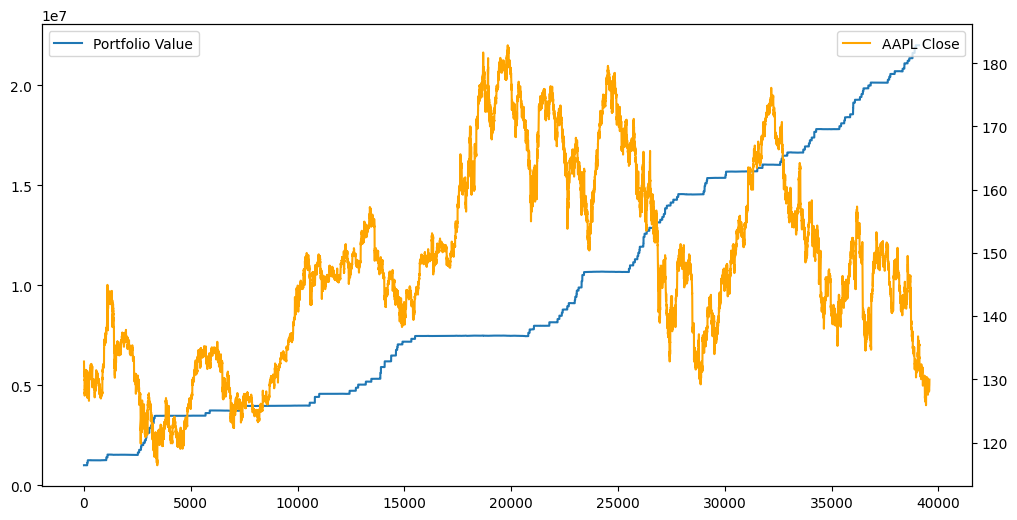

In [9]:
# Mostrar resultados
print("Mejor valor del portafolio:", portfolio_value[-1])
print("Mejores parámetros:", best_params)
print("Métricas finales:")
print(f"Sharpe Ratio: {final_metrics['Sharpe']:.2f}")
print(f"Sortino Ratio: {final_metrics['Sortino']:.2f}")
print(f"Calmar Ratio: {final_metrics['Calmar']:.2f}")
print(f"Win/Loss Percentage: {final_metrics['Win_Loss_Percent']:.2f}%")

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label="Portfolio Value")
plt.legend()
plt.twinx().plot(data.Close, c="orange", label="AAPL Close")
plt.legend(loc="upper right")
plt.show()

### Conclusiones 
